In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate
%matplotlib inline

This reads the PhotometryPlanetRadiiSamplesRedo.csv file that I generated in USPRadiusDistribution.ipynb. It has 1000 radius samples for each USP planet. I make them all into a giant 62000-sample list that I can then slice for each planet.

In [2]:
periodsamples = []
radiisamples = []
kepids = []
meanearthradii = []
radiierrup = []
radiierrdown = []
per = []

## get 1000 planetary radius samples per planet, set up period array
with open('PhotometryPlanetRadiiSamplesRedo2.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        kepids.append(int(row[0]))
        samplelist = list(str(row[1]).split(','))
        samplelist[0] = samplelist[0][1:] # remove brackets
        samplelist[len(samplelist)-1] = samplelist[len(samplelist)-1][:-1] #remove brackets
        sampleslist = [float(i) for i in samplelist]
        meanearthradii.append(np.percentile(sampleslist, 50))
        ##earthradiierr.append(np.std(sampleslist))
        radiierrup.append(np.percentile(sampleslist, 15.85))
        radiierrdown.append(np.percentile(sampleslist, 84.15))
        radiisamples = radiisamples + sampleslist
        rownum += 1


## Spherical integration

In [3]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [4]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [5]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

In [6]:
def get_mass(radius, cmf):
    return getmass((getpcmb(radsample, cmf), getpmaxhat(radsample, cmf)))

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [7]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(get_mass(radsample, 0.33))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(np.nan)
        i = i + 1

print("Mercury")
count = 0
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(get_mass(radsample, 0.7))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        count += 1
        mercurymasssamples.append(np.nan)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(get_mass(radsample, randomcmf))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        randmasssamples.append(np.nan)
        i = i + 1

print(count)

Mercury
could not interpolate for sample 33024
could not interpolate for sample 33029
could not interpolate for sample 33047
could not interpolate for sample 33142
could not interpolate for sample 33143
could not interpolate for sample 33171
could not interpolate for sample 33195
could not interpolate for sample 33240
could not interpolate for sample 33277
could not interpolate for sample 33319
could not interpolate for sample 33400
could not interpolate for sample 33415
could not interpolate for sample 33430
could not interpolate for sample 33436
could not interpolate for sample 33443
could not interpolate for sample 33467
could not interpolate for sample 33512
could not interpolate for sample 33547
could not interpolate for sample 33561
could not interpolate for sample 33573
could not interpolate for sample 33602
could not interpolate for sample 33644
could not interpolate for sample 33696
could not interpolate for sample 33700
could not interpolate for sample 33727
could not interpo

Okay, so there's one planet(index 33) that has some issues (it's the biggest radius one).

In [8]:
meanearthmasses = []
eartherr = []
eartherrup = []
eartherrdown = []

meanmercmasses = []
mercerr = []
mercerrup = []
mercerrdown = []

meanrandmasses = []
randerr = []
randerrup = []
randerrdown = []

earth_num_samples = []
merc_num_samples = []
rand_num_samples = []

file = open('EarthlikeMassSamples21920.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(earthmasssamples) // 1000)):
        list1 = []
        list1 = earthmasssamples[(1000*i) : (1000*(i+1))]
        list2 = list1
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
        earth_num_samples.append(len(list1))
        meanearthmasses.append(np.percentile(list1, 50))
        eartherr.append(np.std(list1))
        eartherrup.append(np.percentile(list1, 15.85))
        eartherrdown.append(np.percentile(list1, 84.15))
        row = [kepids[i]]
        for k in range(0, len(list2)):
            row.append(list2[k])
        writer.writerow(row)

count = 0
file = open('MercuryLikeMassSamples21920.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(mercurymasssamples) // 1000)):
        list1 = []
        list1 = mercurymasssamples[(1000*i) : (1000*(i+1))]
        list2 = list1
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                count += 1
        merc_num_samples.append(len(list1))
        meanmercmasses.append(np.percentile(list1, 50))
        mercerrup.append(np.percentile(list1, 15.85))
        mercerrdown.append(np.percentile(list1, 84.15))
        mercerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list2)):
            row.append(list2[k])
        writer.writerow(row)
      
file = open('RandomCMFMassSamples21920.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(randmasssamples) // 1000)):
        list1 = []
        list1 = randmasssamples[(1000*i) : (1000*(i+1))]
        list2 = list1
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
        rand_num_samples.append(len(list1))
        meanrandmasses.append(np.percentile(list1, 50))
        randerrup.append(np.percentile(list1, 15.85))
        randerrdown.append(np.percentile(list1, 84.15))
        randerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list2)):
            row.append(list2[k])
        writer.writerow(row)
        
print(count)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


34


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


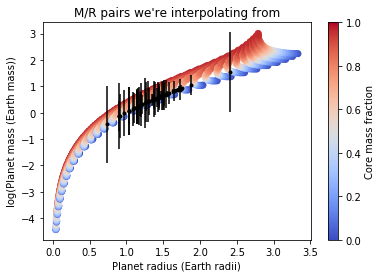

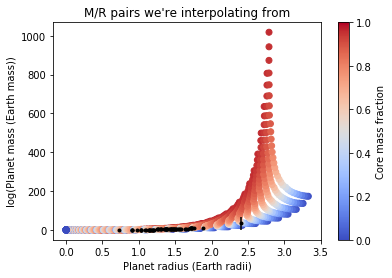

In [9]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), np.log10(planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, np.log10(meanearthmasses),'k.')
plt.errorbar(meanearthradii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(planetrad.flatten(), (planetmass.flatten()), c = cmfarray.flatten(), vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, (meanearthmasses),'k.')
plt.errorbar(meanearthradii, (meanearthmasses),ls= 'none',yerr = (eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

In [10]:
koi = [0, 4144, 2393, 0, 4430, 2880, 3032, 0, 0, 3145, 1202, 2119, 2202, 3065, 2607, 2708, 2668, 2250, 191, 2886, 2753, 2852, 1688, 1128, 2571, 1367, 2756, 2925, 1360, 2817, 4325, 1150, 577, 3106, 2517, 2716, 2874, 2281, 4207, 2735, 2079, 2548, 2409, 2493, 1169, 2589, 4366, 1300, 1428, 1655, 1442, 2492, 1510, 72, 4595, 3009, 4002, 2742, 4441, 3867, 2694, 1875]

In [11]:
per = [0.1973335,0.48765719,0.76669043,0.35500753,0.25255594,0.74092963,0.6364249,0.30598391,0.30160087,0.97730809,0.92831093, 0.57103885,0.81316598,0.89638348,0.75445863,0.86838702,0.67933587,0.62628076,0.70862545,0.88183821,0.93512027,0.675652,0.92103467,0.97486662,0.82628363,0.56785704,0.66502914,0.7165313,0.76401932,0.63400313,0.60992303,0.67737578,0.63816268,0.96896529,0.96852469,0.96286621,0.35251639,0.76985432,0.70194345,0.55884253,0.69384332,0.82715274,0.57736948,0.66308666,0.68920948,0.66407444,0.76295078,0.63133223,0.92785963,0.93846561,0.66931017,0.9849389,0.8399616,0.8374906,0.59701811,0.76486301,0.52417582,0.78916057,0.341842,0.93875053,0.84338039,0.53835457]

In [12]:
periodsamples = [per[i//1000] for i,j in enumerate(radiisamples)]

In [13]:
kepid = []
koi = []
adivr = []
per = []
starrad = []
pradii = []
numstars = []


with open('USPHostProperties.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 0:
             kepid.append(int(row[0]))
             koi.append(int(row[1]))
             adivr.append(float(row[2]))
             per.append(float(row[3]))
             starrad.append(float(row[11]))
             pradii.append(float(row[12]))
             numstars.append(float(row[13]))
         rownum += 1

falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del numstars[k]
    
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
print(len(per))
print(len(numstars))

62
62


In [14]:
periodsamples = [per[i//1000] for i,j in enumerate(radiisamples)]

Okay, now we're going to do the occurrence rate and mass distribution calculations.

## Radius distribution / Occurrence rates

In [15]:
import seaborn as sns

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
radbinsflip = np.flip(radbins,0) ## makes orientation correct on y axis

perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]
array = np.zeros((len(radbins)-1,len(perbins)-1))
scaledarray = np.zeros((len(radbins)-1,len(perbins)-1))
freqarray = np.zeros((len(radbins)-1,len(perbins)-1))

## calculates occurrence rate contribution for each planet sample
f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
kepid2 = []

In [134]:
persampleshours = [i * 24 for i in periodsamples]
contribs2 = [1/1000 for i,j in enumerate(radiisamples)]
freq = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], weights = contribs2)[0], 0)
#print(np.transpose(np.flip(freq, 1)))
print("Frequency array: \n", freq)

## we should divide the contributions by 1000, because 1000 samples per planet
## but then we just multiply by 1000 again because per 1000 stars
contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
occur = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
                               weights = contribs)[0], 0)
print("Occurrence rate array: (per thousand stars) \n", occur * 1000)

## we divide transit contributions by 1000 because 1000 planets per star
transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
transit_array = np.flip(np.histogram2d(radiisamples, persampleshours, bins = [radbins, perbins], 
                                       weights = transit_contribs)[0], 0)
print("Transit array: \n", transit_array)

Frequency array: 
 [[0.0000e+00 0.0000e+00 0.0000e+00 8.6000e-02]
 [0.0000e+00 0.0000e+00 0.0000e+00 8.1000e-01]
 [8.6400e-01 9.1000e-01 7.9200e+00 1.7945e+01]
 [1.1360e+00 4.0780e+00 5.2640e+00 1.7575e+01]
 [0.0000e+00 1.2000e-02 8.1600e-01 4.4310e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.5100e-01]]
Occurrence rate array: (per thousand stars) 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.25615987e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.07246184e-02]
 [6.27843295e-02 2.37650689e-02 3.97967958e-01 1.13866846e+00]
 [5.94954311e-02 2.18795506e-01 3.39824485e-01 1.65368432e+00]
 [0.00000000e+00 1.41777498e-03 6.76231204e-02 1.10659849e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.09635983e-02]]
Transit array: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.95690484e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.71639421e-05]
 [1.81412074e-05 9.18492075e-06 8.63254734e-05 2.33326076e-04]
 [1.64689844e-05 5.63836705e-05 7.72596854e-05 3.43778076e-04]
 [0.

We want to calculate the 68.3% Wilson confidence interval.

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

In [135]:
z = 1
n = freq / transit_array

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [136]:
m = 500
pp = 421/500

z95 = 1.96
root = ((pp * (1-pp)) / m+ (z95**2)/(4*(m**2)))**0.5
denom = 1 + (z95**2)/m
high = (pp + (z95**2)/(2*m) + z95*root)/denom
low = (pp + (z95**2)/(2*m) - z95*root)/denom
print(high, low)


0.8713477936271825 0.8074369672976796


In [158]:
upper = np.zeros_like(occur)
lower = np.zeros_like(occur)
for i in range(len(occur)):
    for j in range(len(occur[0])):
        if np.isnan(n[i][j]) == False:
#             print("Number planets:" ,freq[i][j])
#             print("Number stars: ", n[i][j])
            p = transit_array[i][j]
            root = ((p * (1-p)) / n[i][j] + (z**2)/(4*(n[i][j]**2)))**0.5
            denom = 1 + (z**2)/n[i][j]
            high = (p + (z**2)/(2*n[i][j]) + z*root)/denom
            low = (p + (z**2)/(2*n[i][j]) - z*root)/denom
#             print("upper", "middle", "lower")
#             print(high * 1000, p * 1000, low * 1000)
#             print(high * 1000- p * 1000)
            upper[i][j] = 1000*(occur[i][j]/transit_array[i][j])*high - 1000*occur[i][j]
            lower[i][j] = 1000*occur[i][j] - 1000*(occur[i][j]/transit_array[i][j])*low
            #print(p* n[i][j], n[i][j])
print("upper: \n", upper)
# print("value: \n", occur * 1000)
# print("lower: \n", lower)

upper: 
 [[0.         0.         0.         0.11620015]
 [0.         0.         0.         0.15243067]
 [0.1130266  0.04118418 0.16873835 0.30234034]
 [0.08784146 0.13843657 0.18385545 0.44419557]
 [0.         0.11954644 0.12699366 0.6650747 ]
 [0.         0.         0.         0.38244306]]


In [114]:
occur[i][j]/transit_array[i][j]

4.169448616209512

<Figure size 640x480 with 0 Axes>

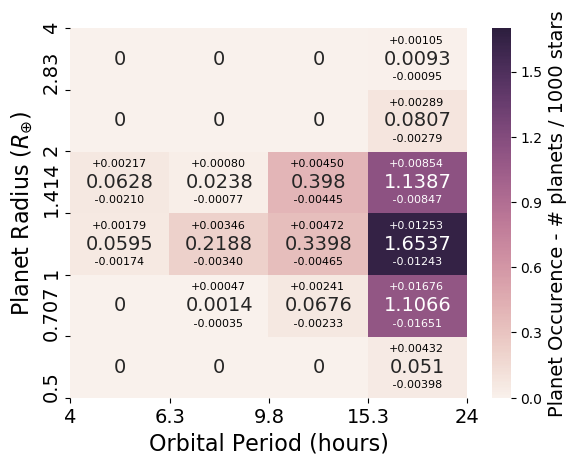

In [116]:
import matplotlib as mpl
mpl.style.use('default')

r = plt.figure()
labels = np.array([[0,0,0,0.0093],[0,0,0,0.0807],[0.0628,0.0238,0.3980,1.1387],[0.0595,0.2188,0.3398,1.6537],[0,0.0014,0.0676,1.1066],[0,0,0,0.0510]],dtype = object)
fig, ax = plt.subplots()
ax = sns.heatmap(1000*occur, annot = labels, fmt = '', annot_kws={"size": 14}, vmin=0, vmax=1.7)
plt.text(3.21,5.75,"+0.00105", size = 8)
plt.text(3.21,5.16," -0.00095", size = 8)
plt.text(3.21,4.75,"+0.00289", size = 8)
plt.text(3.21,4.16," -0.00279", size = 8)
plt.text(0.21,3.75,"+0.00217", size = 8)
plt.text(0.21,3.16," -0.00210", size = 8)
plt.text(1.21,3.75,"+0.00080", size = 8)
plt.text(1.21,3.16," -0.00077", size = 8)
plt.text(2.21,3.75,"+0.00450", size = 8)
plt.text(2.21,3.16," -0.00445", size = 8)
plt.text(3.21,3.75,"+0.00854", color = 'w', size = 8)
plt.text(3.21,3.16," -0.00847", color = 'w', size = 8)
plt.text(0.21,2.75,"+0.00179", size = 8)
plt.text(0.21,2.16," -0.00174", size = 8)
plt.text(1.21,2.75,"+0.00346", size = 8)
plt.text(1.21,2.16," -0.00340", size = 8)
plt.text(2.21,2.75,"+0.00472", size = 8)
plt.text(2.21,2.16," -0.00465", size = 8)
plt.text(3.21,2.75,"+0.01253", color = 'w', size = 8)
plt.text(3.21,2.16," -0.01243", color = 'w', size = 8)
plt.text(1.21,1.75,"+0.00047", size = 8)
plt.text(1.21,1.16," -0.00035", size = 8)
plt.text(2.21,1.75,"+0.00241", size = 8)
plt.text(2.21,1.16," -0.00233", size = 8)
plt.text(3.21,1.75,"+0.01676", color = 'w', size = 8)
plt.text(3.21,1.16," -0.01651", color = 'w', size = 8)
plt.text(3.21,0.75,"+0.00432", size = 8)
plt.text(3.21,0.16," -0.00398", size = 8)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,0.707,1,1.414,2,2.83,4], fontsize = 14, horizontalalignment = 'right', verticalalignment = 'baseline')
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets / 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Radius ($R_{\oplus}$)", fontsize = 16)

plt.show()
r.savefig("OccurrenceRates.pdf", bbox_inches='tight')

## Mass Distribution

In [286]:
massbins = [0.5,1,2,4,8,16,32]
massbins2 = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2) ## twice as many mass bins
massbinsflip = np.flip(massbins,0)

def occur_freq_transit(masssamples, persampleshours, massbins, perbins):
    contribs = [(f[i//1000])/1000 for i,j in enumerate(masssamples)]
    contribs2 = [1/1000 for i,j in enumerate(masssamples)]
    occur = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                               weights = contribs)[0], 0)
    freq = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
    transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
    transit = np.flip(np.histogram2d(masssamples, persampleshours, bins = [massbins, perbins], 
                                       weights = transit_contribs)[0], 0)
    return occur, freq, transit

mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)
mass_occur_earth2, mass_freq_earth2, mass_transit_earth2 = occur_freq_transit(earthmasssamples, persampleshours, massbins2, perbins)

mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)
mass_occur_merc2, mass_freq_merc2, mass_transit_merc2 = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)

# ## we should divide the contributions by 1000, because 1000 samples per planet
# ## but then we just multiply by 1000 again because per 1000 stars
# contribs = [(f[i//1000])/1000 for i,j in enumerate(radiisamples)]
# contribs2 = [1/1000 for i,j in enumerate(radiisamples)]
# mass_occur_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_occur_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# print("Occurrence rate array (Earth-like masses): (per thousand stars) \n", mass_occur_earth * 1000)

# mass_freq_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)
# mass_freq_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# print("Frequency (Earth-like masses): \n", mass_freq_earth)

# ## we divide transit contributions by 1000 because 1000 planets per star
# transit_contribs = [(1/numstars[i//1000])/1000 for i,j in enumerate(radiisamples)]
# mass_transit_earth = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_transit_earth2 = np.flip(np.histogram2d(earthmasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# print("Transit array: (Earth-like masses)\n", mass_transit_earth)

# mass_occur_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins, perbins], weights = contribs2)[0], 0)


# mass_occur_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                weights = contribs)[0], 0)
# mass_transit_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], 
#                                        weights = transit_contribs)[0], 0)
# mass_freq_merc2 = np.flip(np.histogram2d(mercurymasssamples, persampleshours, bins = [massbins2, perbins], weights = contribs2)[0], 0)

# a, b, c = occur_freq_transit(mercurymasssamples, persampleshours, massbins2, perbins)
# print(np.isclose(a, mass_occur_merc2))
# print(np.isclose(b, mass_freq_merc2))
# print(np.isclose(c, mass_transit_merc2))

In [287]:
mass_occur_earth_sum = np.flip((mass_occur_earth).sum(axis = 1))

(0, 50)

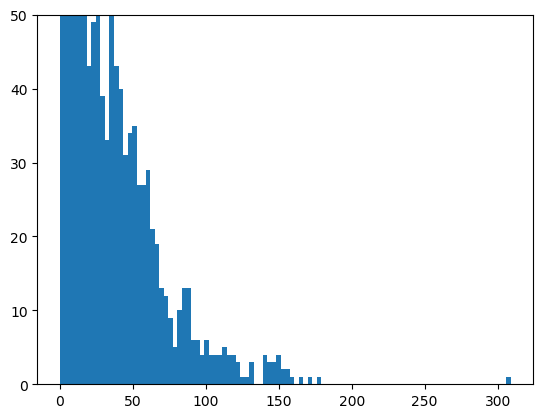

In [288]:
plt.hist(earthmasssamples, 100)
plt.ylim(0,50)

## Tidal distortion masses

In [289]:
short_period_indices = []
for i, j in enumerate([p * 24 for p in per]):
    if j < 10:
        short_period_indices.append(i)

In [290]:
M_star = np.loadtxt("USPHostMasses.txt")

In [291]:
np.savetxt("Short_period_logMs_per_rad.txt", np.column_stack(([np.log10(M_star[i]) for i in short_period_indices],
                                         [per[i] * 24 for i in short_period_indices],
                                         [meanearthradii[i] for i in short_period_indices])))


### Calculating uncertainties on earth-like mass distribution

In [292]:
def occur_uncert(occur, freq, transit, z = 1):
    upper = np.zeros_like(occur)
    lower = np.zeros_like(occur)
    n = freq / transit
    for i in range(len(occur)):
        for j in range(len(occur[0])):
            if np.isnan(n[i][j]) == False:
                p = transit[i][j]
                root = (((p * (1-p)) / n[i][j]) + (z**2)/(4*(n[i][j]**2)))**0.5
                denom = 1 + (z**2)/n[i][j]
                high = (p + (z**2)/(2*n[i][j]) + z*root)/denom
                low = (p + (z**2)/(2*n[i][j]) - z*root)/denom
                upper[i][j] = (occur[i][j]/transit[i][j])*high * 1000 - (occur[i][j]/transit[i][j])*p * 1000
                lower[i][j] = (occur[i][j]/transit[i][j])*p * 1000 - (occur[i][j]/transit[i][j])*low * 1000
    return upper, lower




upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)

# upper_earth = np.zeros_like(mass_occur_earth)
# lower_earth = np.zeros_like(mass_occur_earth)
# n_earth = mass_freq_earth / mass_transit_earth
# for i in range(len(mass_occur_earth)):
#     for j in range(len(mass_occur_earth[0])):
#         if np.isnan(n_earth[i][j]) == False:
#             p = mass_transit_earth[i][j]
#             root = ( (p * (1-p)) / n_earth[i][j]) ** 0.5
#             high = p + z * root
#             low  = p - z * root
#             upper_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*high * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000
#             lower_earth[i][j] = (mass_occur_earth[i][j]/mass_transit_earth[i][j])*p * 1000 - (mass_occur_earth[i][j]/mass_transit_earth[i][j])*low * 1000

print("upper: \n", upper_earth)
print("actual: \n", mass_occur_earth * 1000)
print("lower: \n", lower_earth)

upper: 
 [[0.         0.         0.         0.11825998]
 [0.08064779 0.         0.06813397 0.14182523]
 [0.11022522 0.03164929 0.15037072 0.26921739]
 [0.09254607 0.09817154 0.15771552 0.26159553]
 [0.05875044 0.12551526 0.14539221 0.43813161]
 [0.         0.11896663 0.11998704 0.53767921]]
actual: 
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.72895650e-02]
 [1.42646423e-03 0.00000000e+00 3.94426893e-02 2.09395381e-01]
 [5.11293971e-02 7.19473162e-03 2.97678493e-01 8.44095420e-01]
 [6.77900084e-02 1.34818116e-01 2.55906425e-01 7.45543921e-01]
 [1.93389087e-03 1.01138467e-01 1.59120578e-01 1.07044782e+00]
 [0.00000000e+00 8.27035407e-04 5.32673785e-02 7.00551139e-01]]
lower: 
 [[0.         0.         0.         0.02217306]
 [0.00140167 0.         0.02498128 0.08455684]
 [0.03492808 0.00586213 0.09990664 0.20412455]
 [0.03912885 0.05680733 0.09757996 0.19365661]
 [0.00187226 0.05600873 0.075975   0.31090549]
 [0.         0.00082133 0.03689057 0.30421436]]


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Now I'm going to smush the grid into a 1d array, adding the errors in quadrature.

In [293]:
def smush_uncert(occur, upper, lower):
    occur_sum = np.flip((occur).sum(axis = 1))
    sum_upper = np.zeros_like(occur_sum)
    sum_lower = np.zeros_like(occur_sum)
    for i in range(len(occur)):
        errup = 0
        errdown = 0
        for j in upper[i]:
            errup += j**2
        for k in lower[i]:
            errdown += k**2
        sum_upper[i] = (errup**0.5)
        sum_lower[i] = (errdown**0.5)
    return occur_sum, sum_upper, sum_lower

# mass_earth_sum_upper = np.zeros_like(mass_occur_earth_sum)
# mass_earth_sum_lower = np.zeros_like(mass_occur_earth_sum)

# for i in range(len(n_earth)):
#     errup = 0
#     errdown = 0
#     for j in upper_earth[i]:
#         errup += j**2
#     for k in lower_earth[i]:
#         errdown += k**2
#     mass_earth_sum_upper[i] = (errup**0.5)
#     mass_earth_sum_lower[i] = (errdown**0.5)

mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)
print(mass_earth_sum_lower, mass_earth_sum_upper)

[0.02217306 0.088181   0.23000544 0.2275585  0.32492293 0.30644407] [0.11825998 0.17680695 0.32899944 0.33392939 0.48197915 0.56360348]


In [294]:
# mass_occur_merc_sum = np.flip((mass_occur_merc).sum(axis = 1))

# upper_merc = np.zeros_like(mass_occur_merc)
# lower_merc = np.zeros_like(mass_occur_merc)
# n_merc = mass_freq_merc / mass_transit_merc
# for i in range(len(mass_occur_merc)):
#     for j in range(len(mass_occur_merc[0])):
#         if np.isnan(n_merc[i][j]) == False:
#             p = mass_transit_merc[i][j]
#             root = ((p * (1-p)) / n_merc[i][j] + (z**2)/(4*(n_merc[i][j]**2)))**0.5
#             denom = 1 + (z**2)/n_merc[i][j]
#             high = (p + (z**2)/(2*n_merc[i][j]) + z*root)/denom
#             low = (p + (z**2)/(2*n_merc[i][j]) - z*root)/denom
#             upper_merc[i][j] = 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*high - 1000*mass_occur_merc[i][j]
#             lower_merc[i][j] = 1000*mass_occur_merc[i][j] - 1000*(mass_occur_merc[i][j]/mass_transit_merc[i][j])*low
            
            
# print("upper: \n", upper_merc)
# #print("lower: \n", lower_merc)


upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)



# mass_merc_sum_upper = np.zeros_like(mass_occur_merc_sum)
# mass_merc_sum_lower = np.zeros_like(mass_occur_merc_sum)

# for i in range(len(n_merc)):
#     errup = 0
#     errdown = 0
#     for j in upper_merc[i]:
#         errup += j**2
#     for k in lower_merc[i]:
#         errdown += k**2
#     mass_merc_sum_upper[i] = (errup**0.5)
#     mass_merc_sum_lower[i] = (errdown**0.5)
    
    
mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)
# print(mass_merc_sum_lower, mass_merc_sum_upper)
# print(np.isclose(mu, mass_merc_sum_upper))
# print(np.isclose(ml, mass_merc_sum_lower))
# print(ml)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Mass Distribution Graph

In [373]:
rand_array = []

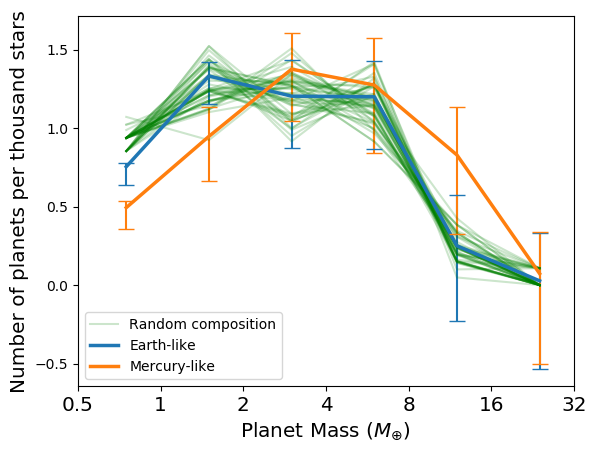

In [381]:
massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
    
    
for i in range(0, 50):
    randmasses = []
    for radsample in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            randmasses.append(get_mass(radsample, randomcmf))
        except:
            print("could not interpolate for sample", i, "cmf = ", randomcmf)
            randmasses.append(np.nan)
#     plt.hist(randmasses)
#     plt.show()
            
    rand_array.append(randmasses)
    mass_occur_rand = np.flip(np.histogram2d(randmasses, [i * 24 for i in per], bins = [massbins, perbins], 
                               weights = f)[0], 0)

    mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
    plt.plot(massticks, mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
plt.plot(massticks, mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
plt.errorbar(massticks,mass_occur_earth_sum * 1000, yerr = np.stack((mass_earth_sum_upper,mass_earth_sum_lower)), linestyle = 'None', ecolor = 'tab:blue', capsize = 6)
plt.errorbar(massticks,mass_occur_merc_sum * 1000, yerr = np.stack((mass_merc_sum_upper,mass_merc_sum_lower)), linestyle = 'None', ecolor = 'tab:orange', capsize = 6)

plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
plt.legend()


In [375]:
np.shape(rand_array)

(50, 62)

In [385]:
def plot_mass_dist(massbins):
#     global meanearthradii, perbins, f, massbins
    
    mass_occur_earth, mass_freq_earth, mass_transit_earth = occur_freq_transit(earthmasssamples, persampleshours, massbins, perbins)

    mass_occur_merc, mass_freq_merc, mass_transit_merc = occur_freq_transit(mercurymasssamples, persampleshours, massbins, perbins)

    upper_earth, lower_earth = occur_uncert(mass_occur_earth, mass_freq_earth, mass_transit_earth)
    mass_occur_earth_sum, mass_earth_sum_upper, mass_earth_sum_lower =  smush_uncert(mass_occur_earth, upper_earth, lower_earth)

    upper_merc, lower_merc = occur_uncert(mass_occur_merc, mass_freq_merc, mass_transit_merc)
    mass_occur_merc_sum, mass_merc_sum_upper, mass_merc_sum_lower  =  smush_uncert(mass_occur_merc, upper_merc, lower_merc)


    massticks = np.zeros(len(massbins)-1) 
    for i in range(len(massbins)-1):
        massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)


    for i, j in enumerate(rand_array):
        
        mass_occur_rand = np.flip(np.histogram2d(j, [i * 24 for i in per], bins = [massbins, perbins], 
                                   weights = f)[0], 0)

        mass_occur_rand_sum = np.flip((mass_occur_rand).sum(axis = 1))
        plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g')
    plt.plot(massticks,mass_occur_rand_sum * 1000, alpha = 0.2, color = 'g', label = 'Random composition')
    plt.plot(massticks,mass_occur_earth_sum * 1000, label = 'Earth-like', linewidth = 2.5, color = 'tab:blue')
    plt.plot(massticks,mass_occur_merc_sum * 1000, label = 'Mercury-like', linewidth = 2.5, color = 'tab:orange')
    plt.errorbar(massticks,mass_occur_earth_sum * 1000, yerr = np.stack((mass_earth_sum_upper,mass_earth_sum_lower)), linestyle = 'None', ecolor = 'tab:blue', capsize = 6)
    plt.errorbar(massticks,mass_occur_merc_sum * 1000, yerr = np.stack((mass_merc_sum_upper,mass_merc_sum_lower)), linestyle = 'None', ecolor = 'tab:orange', capsize = 6)

    plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32], fontsize = 'x-large')
    plt.xlabel('Planet Mass ($M_{ \oplus}$)', fontsize = 'x-large')
    plt.ylabel('Number of planets per thousand stars', fontsize = 'x-large')
    plt.legend()
    plt.show()

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


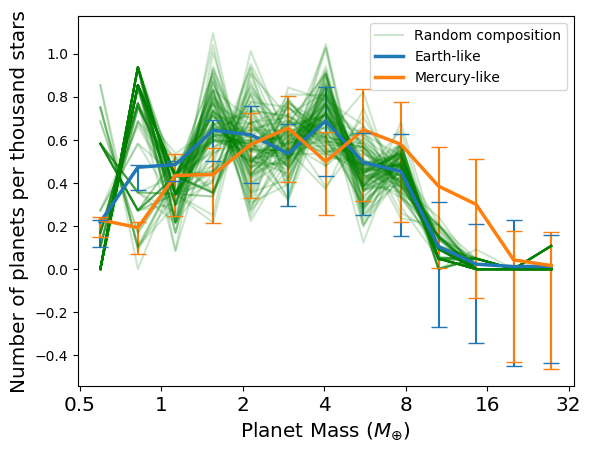

In [386]:
plot_mass_dist(massbins2)

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


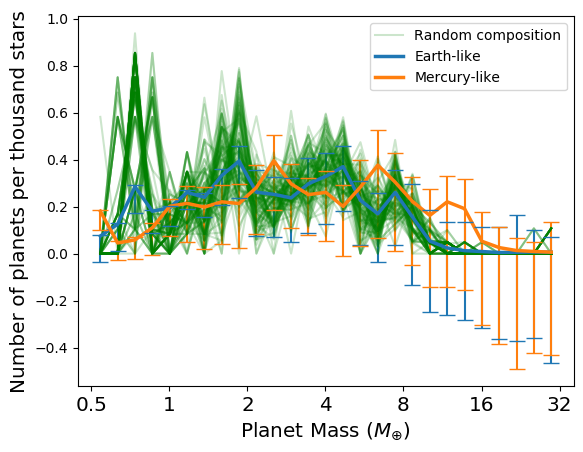

In [388]:
plot_mass_dist(np.logspace(np.log2(0.5), np.log2(32), 28, base = 2))

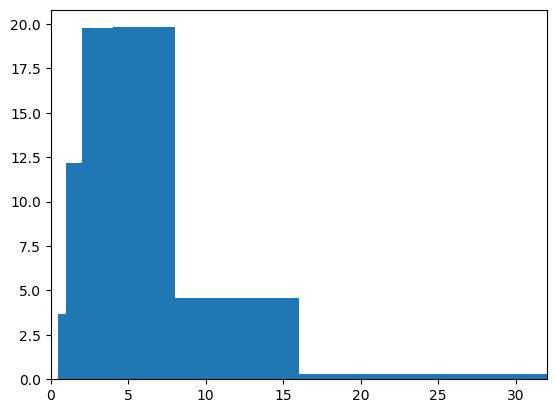

In [164]:
plt.hist(earthmasssamples, bins = massbins, weights = contribs2)
plt.xlim(0,32)
plt.show()

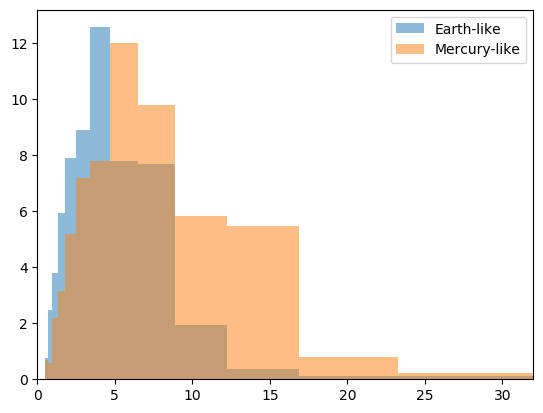

In [296]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2, alpha = 0.5, label = "Earth-like")
plt.hist(mercurymasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 14, base = 2), weights = contribs2,  alpha = 0.5, label = "Mercury-like")
plt.legend()
plt.xlim(0,32)
plt.show()

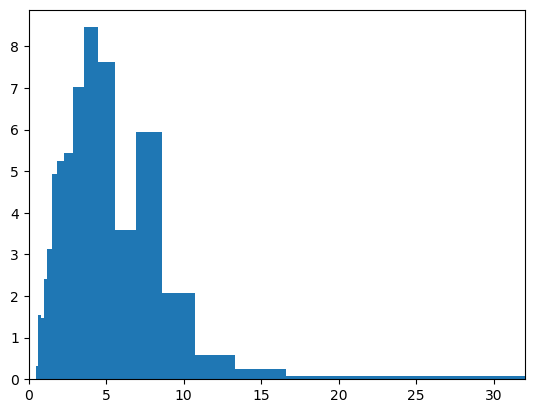

In [179]:
plt.hist(earthmasssamples, bins = np.logspace(np.log2(0.5), np.log2(32), 20, base = 2), weights = contribs2)
plt.xlim(0,32)
plt.show()

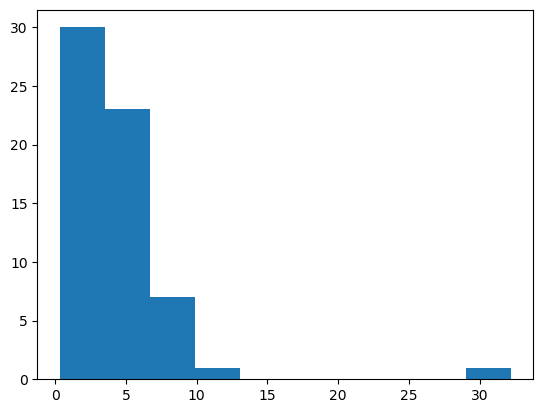

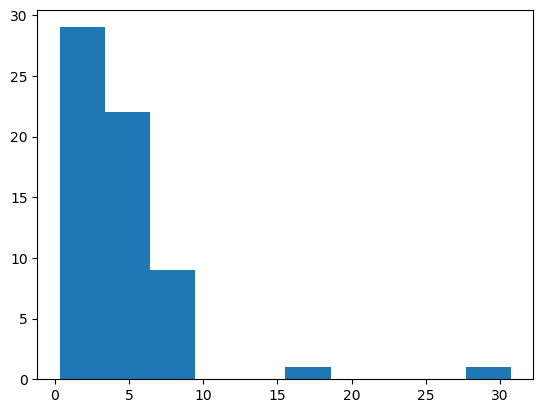

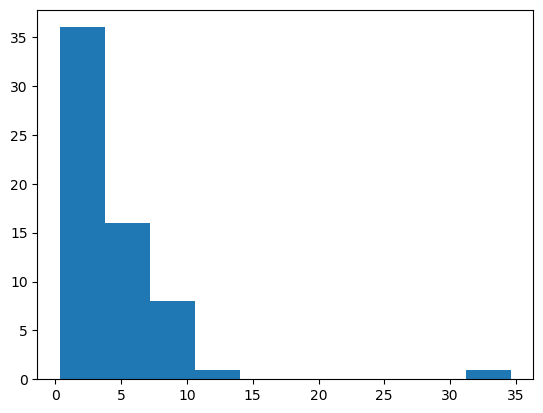

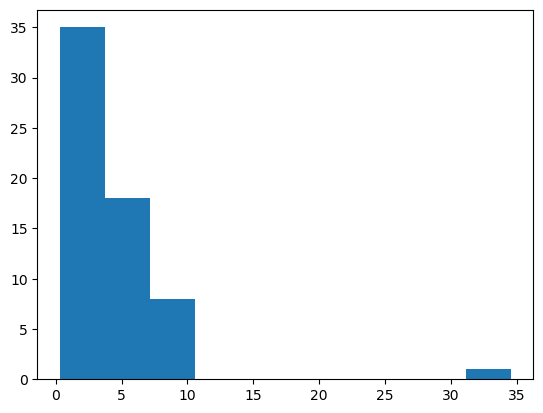

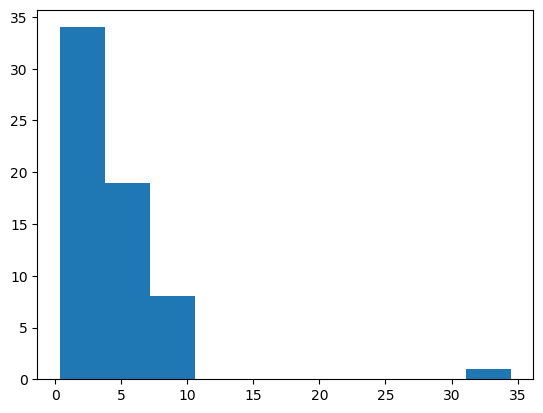

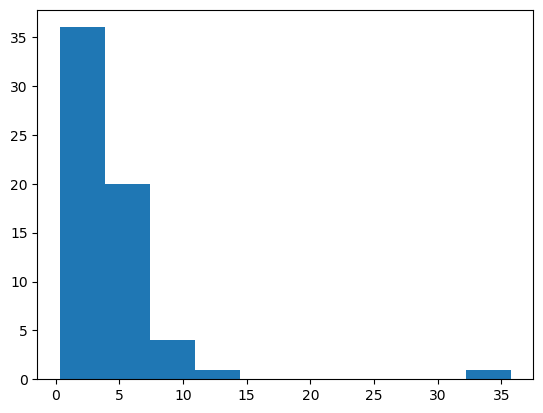

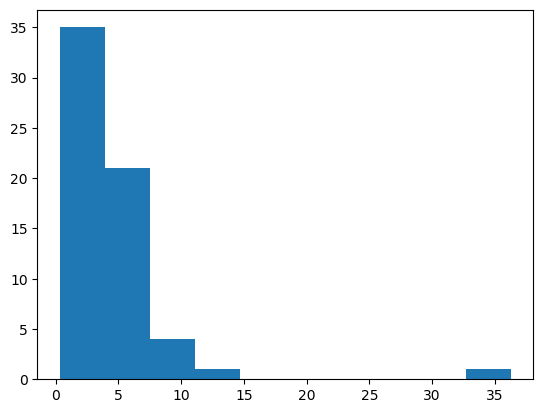

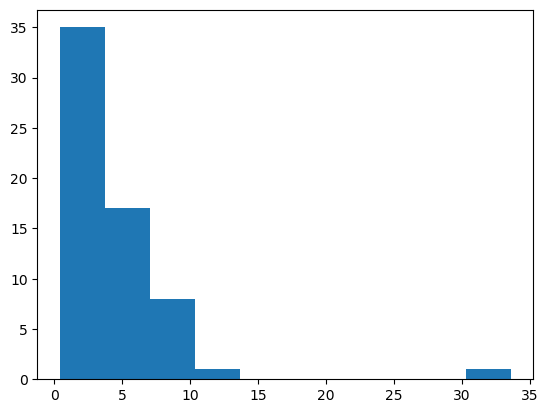

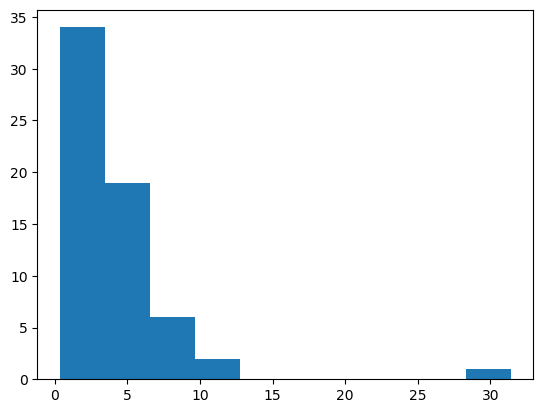

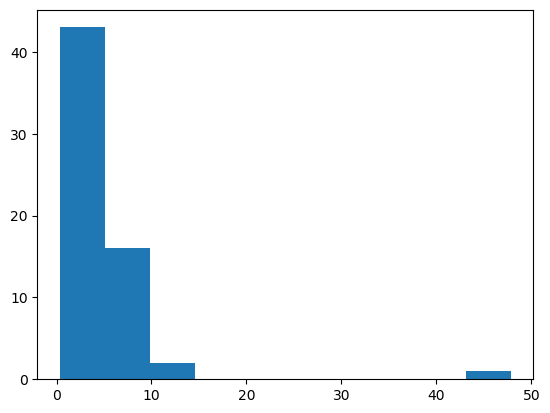

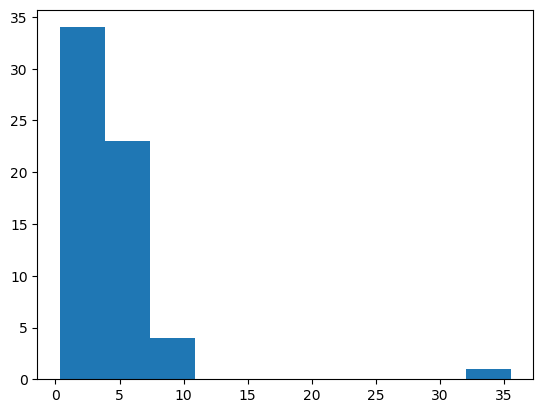

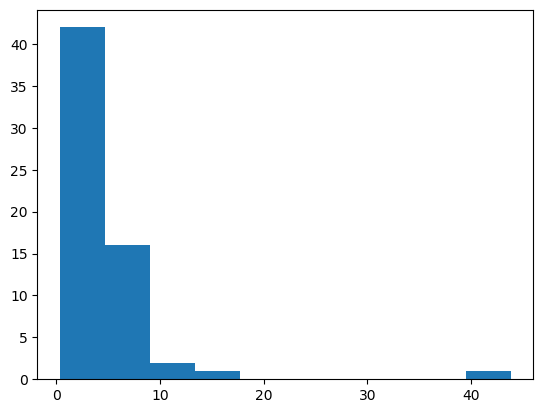

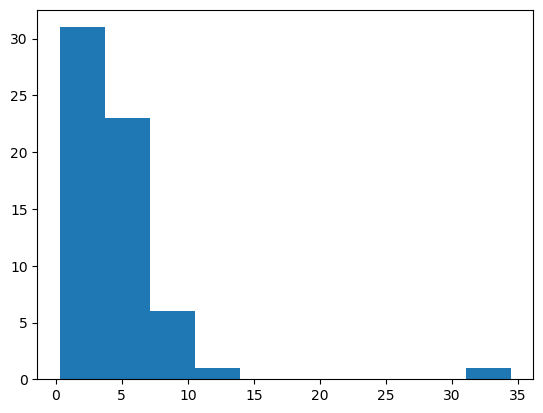

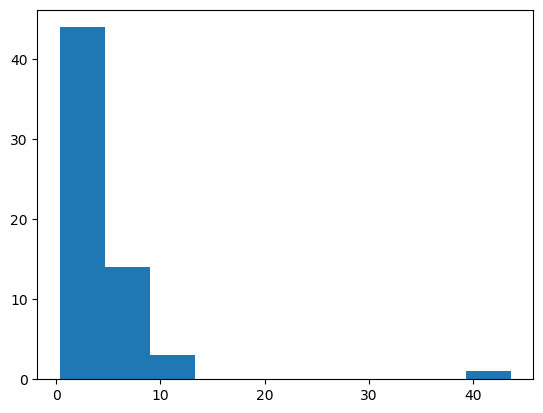

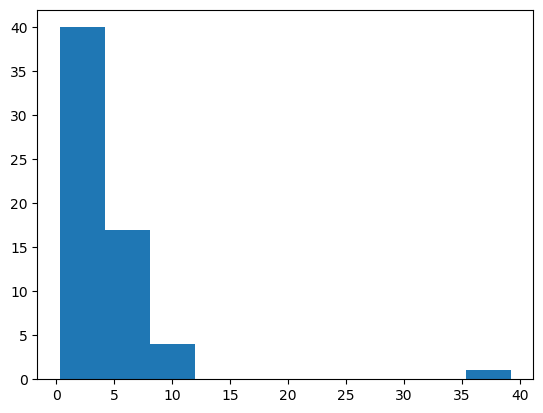

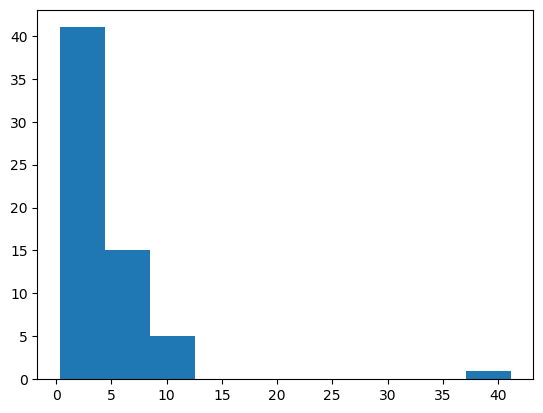

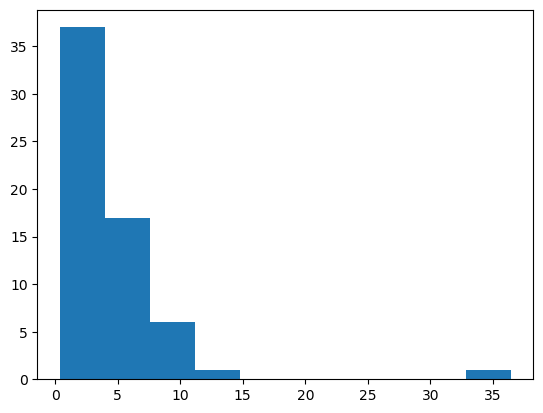

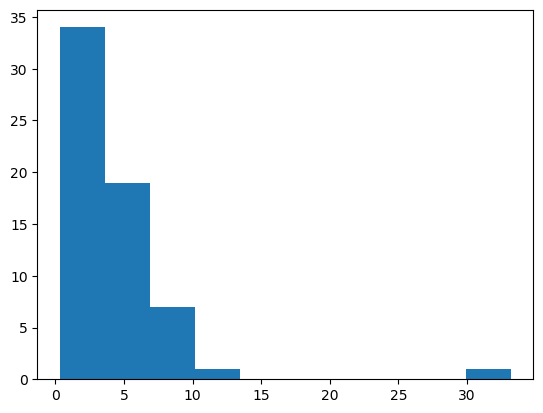

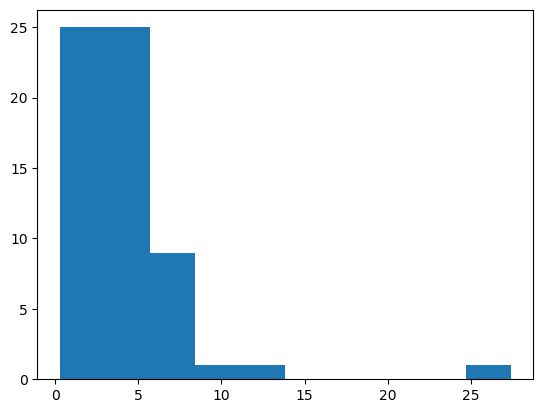

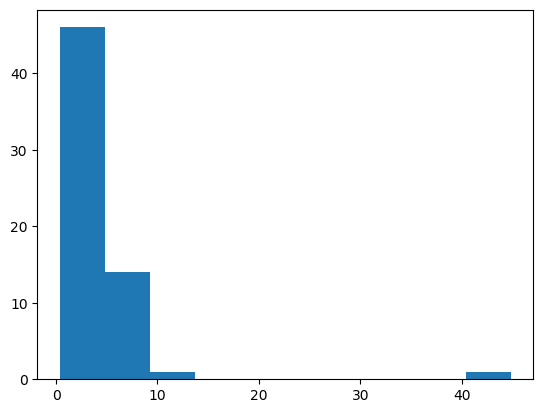

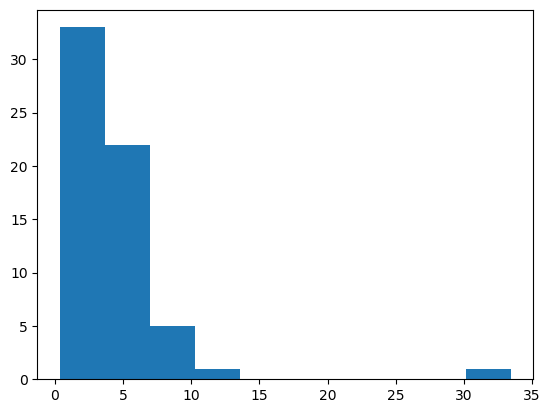

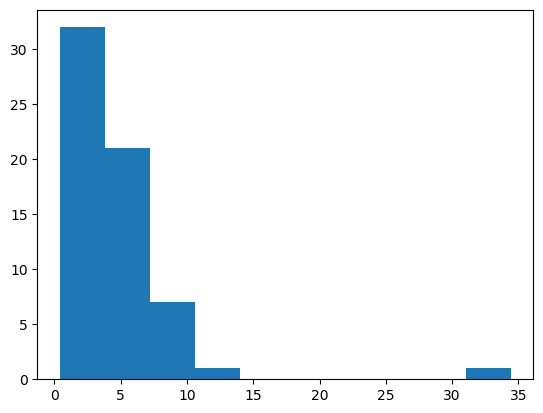

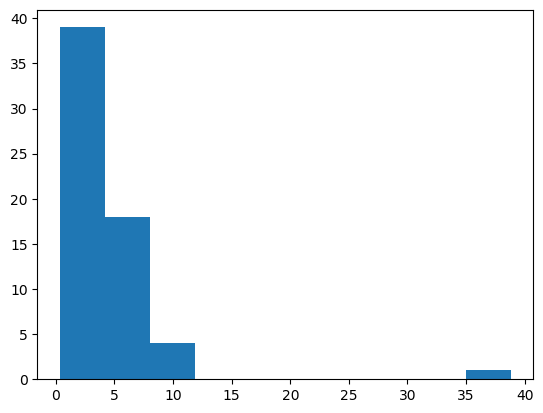

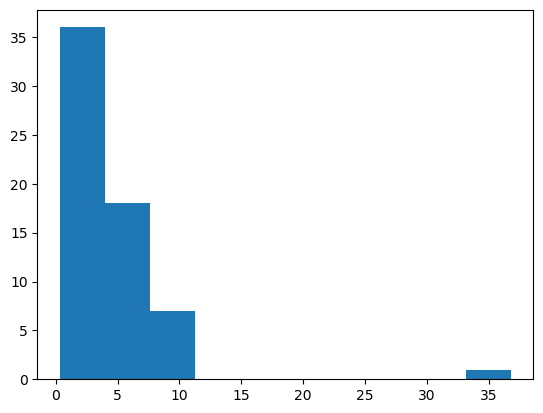

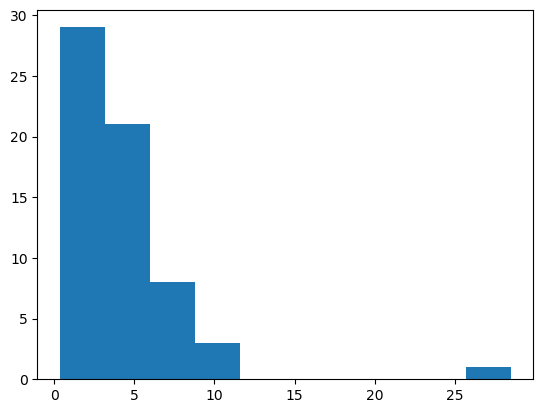

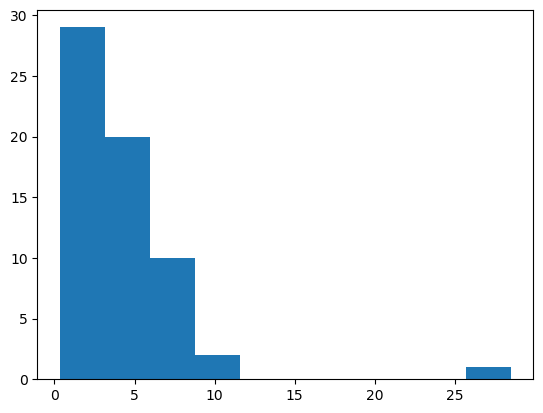

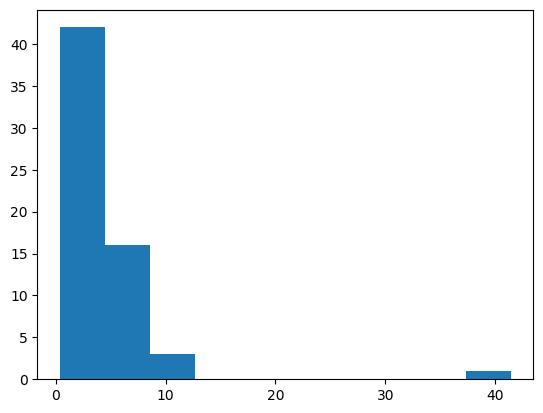

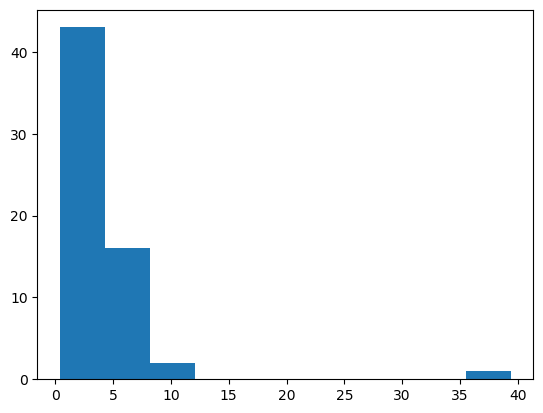

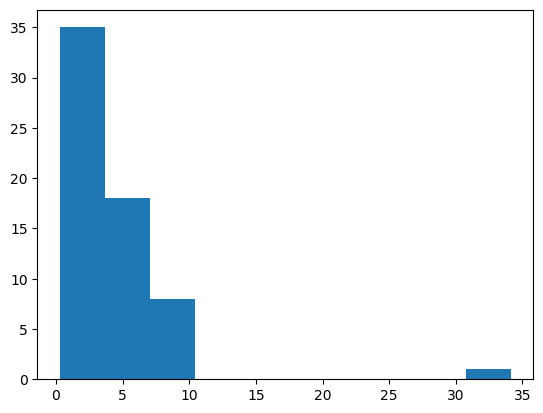

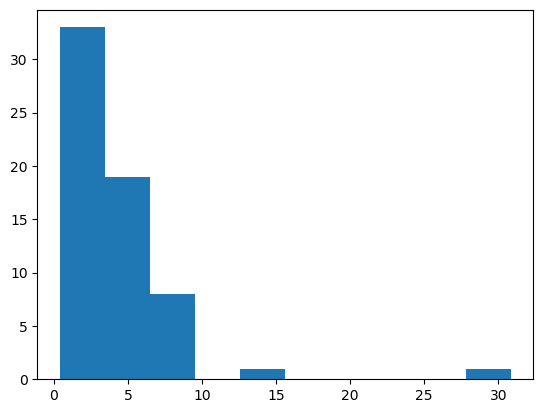

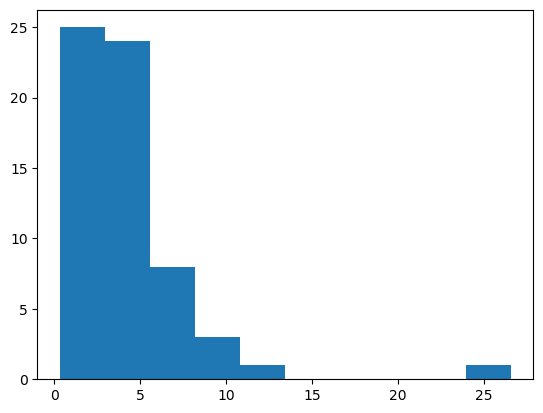

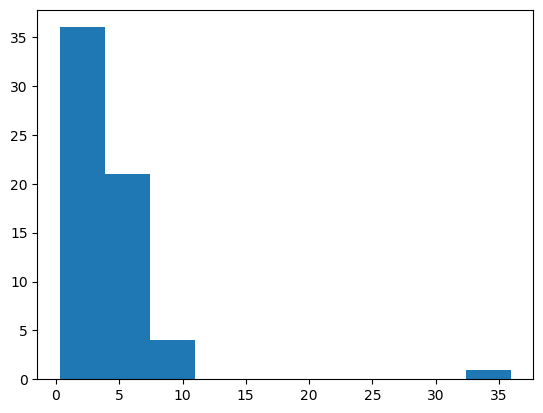

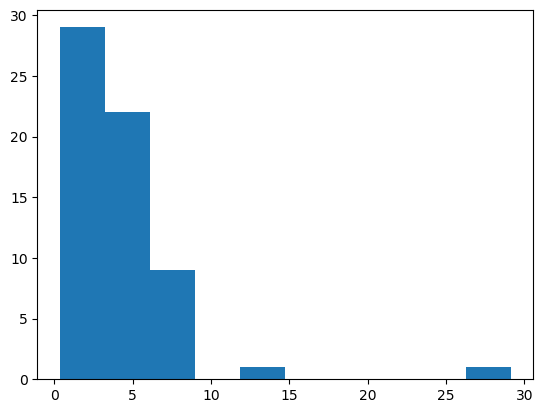

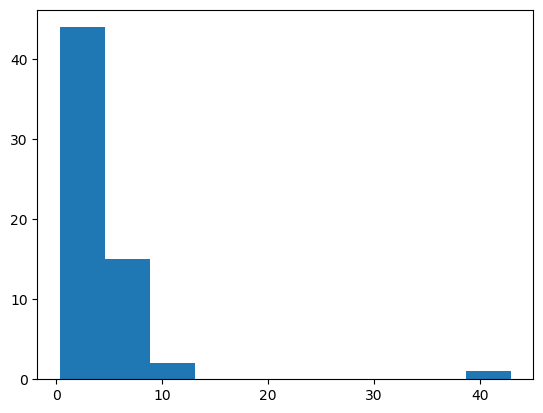

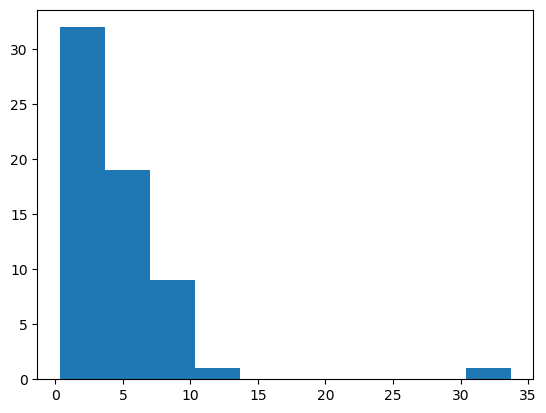

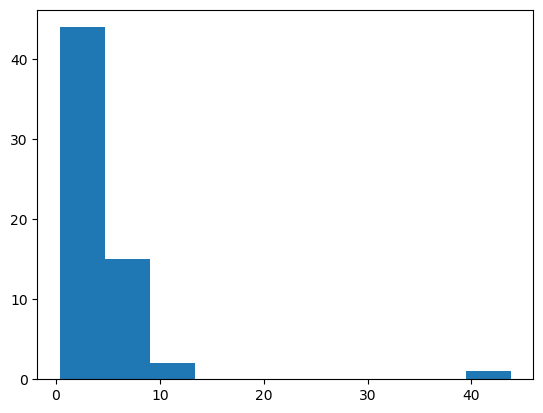

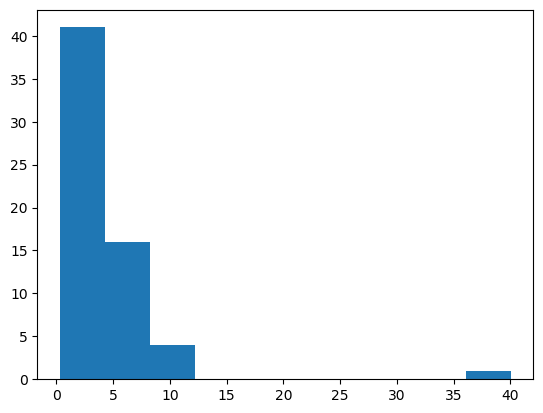

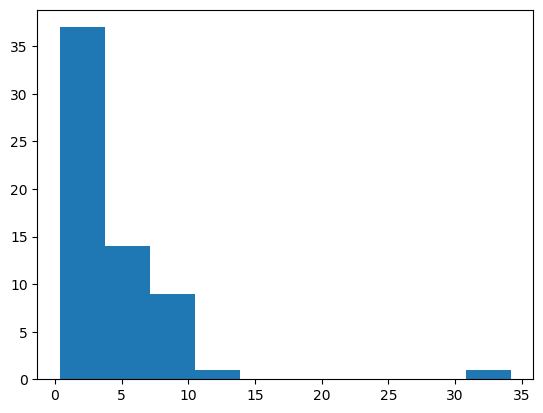

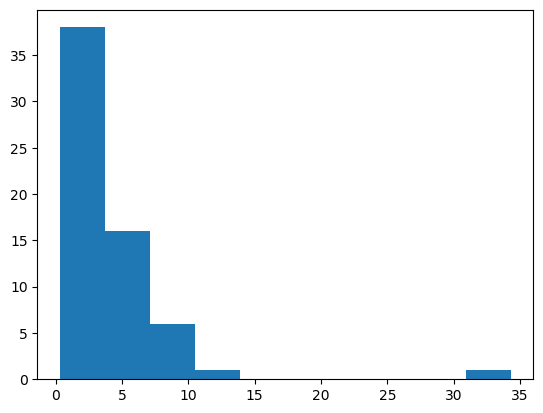

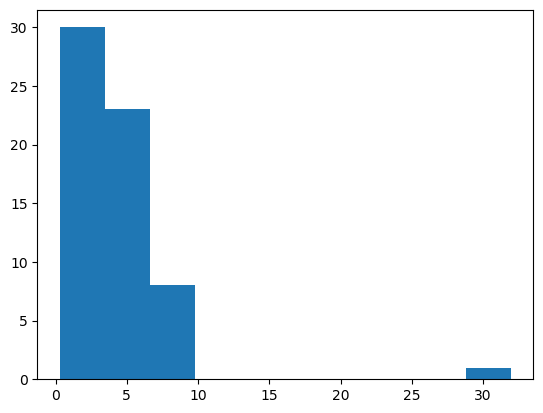

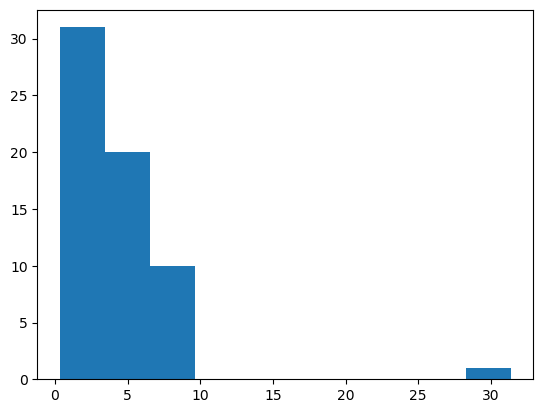

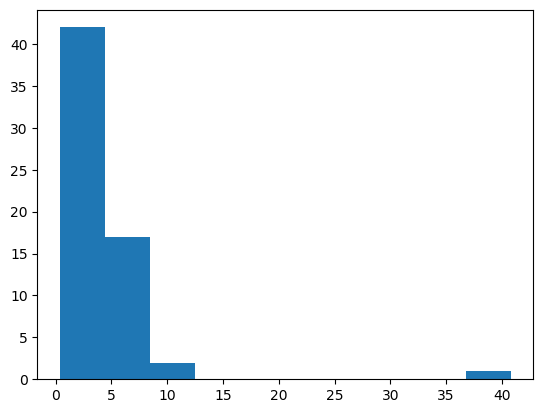

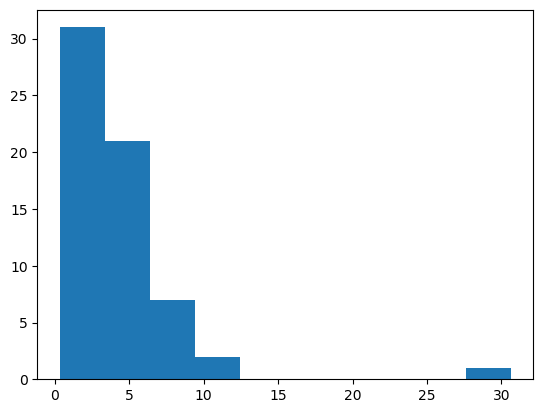

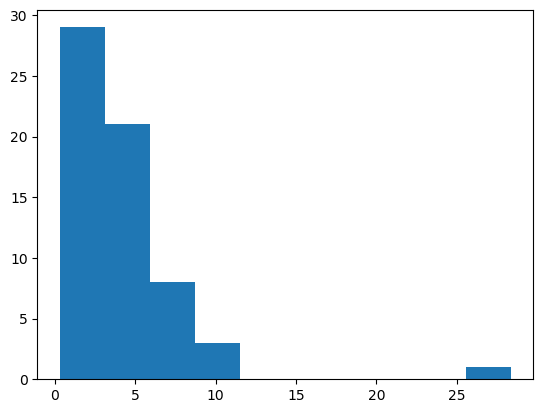

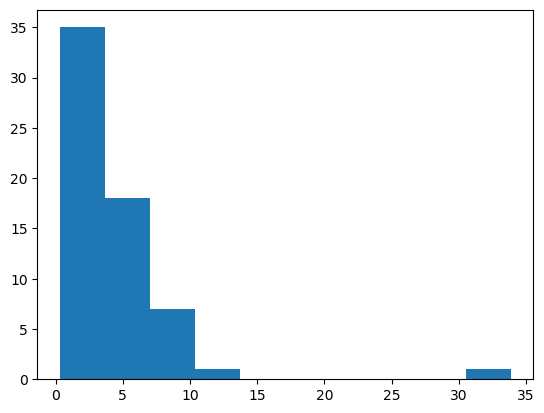

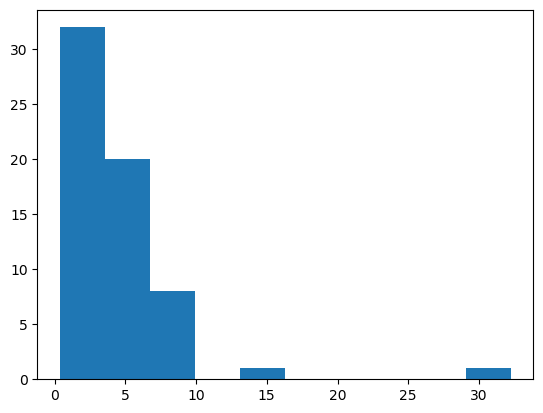

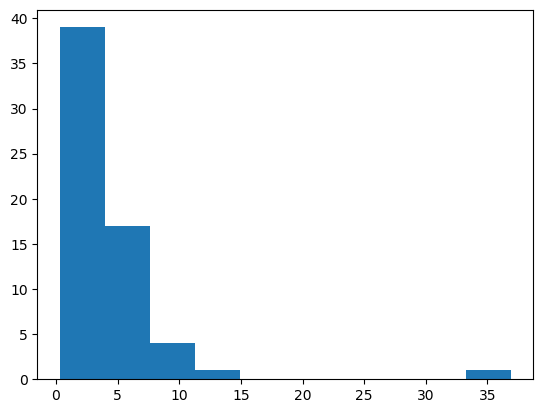

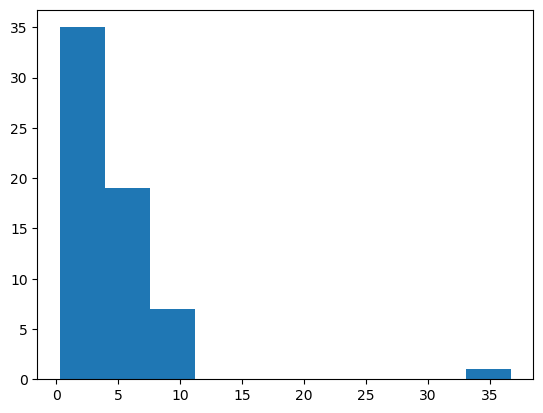

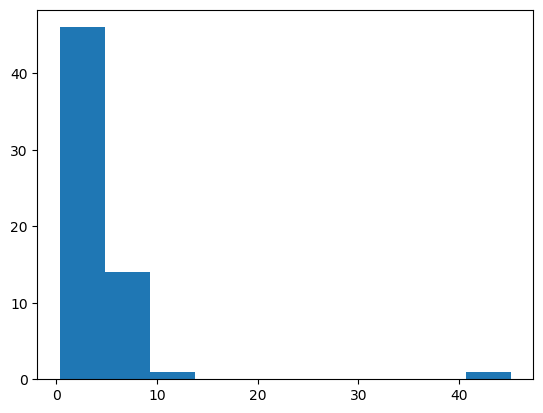

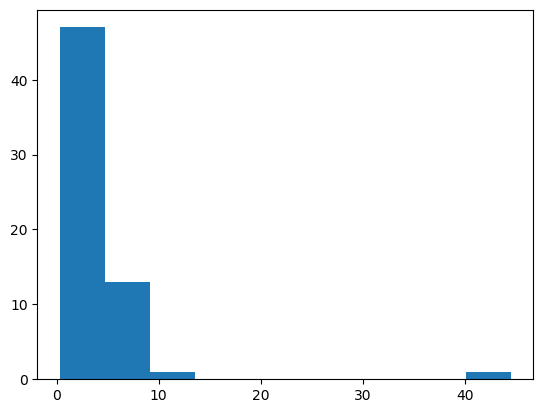

In [337]:
for i in range(0, 50):
    randmasses = []
    for radsample in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            m = get_mass(radsample, randomcmf)
            randmasses.append(m)
        except:
            print("could not interpolate for sample", i, "cmf = ", randomcmf)
            randmasses.append(np.nan)
    plt.hist(randmasses)
    plt.show()

In [371]:
f

[7.924801284285072e-05,
 7.677704890714877e-05,
 6.131730444305111e-05,
 3.76827631638806e-05,
 4.303174772224793e-05,
 7.338301349708755e-05,
 5.814417843527647e-05,
 0.00011814791522535429,
 2.55149910216919e-05,
 5.983375375147878e-05,
 5.953340756990502e-05,
 4.4866204963078425e-05,
 6.631220297947436e-05,
 0.0001371689945519968,
 0.00013233124941277463,
 6.520385210983325e-05,
 4.934306174042931e-05,
 4.274947091201298e-05,
 4.431541752126526e-05,
 6.0890399486052e-05,
 0.0002613483390635949,
 3.070779501409521e-05,
 5.445851757901634e-05,
 6.011587556619002e-05,
 0.0001496398957733031,
 4.471945076928695e-05,
 5.864588429355856e-05,
 0.0005821302876202301,
 0.0001036539111116492,
 5.585350020242243e-05,
 5.529120648795924e-05,
 8.20177468081752e-05,
 8.367610320444562e-05,
 0.00010762976595545821,
 0.00013991188248648268,
 4.877414498550798e-05,
 3.430105531552664e-05,
 0.00016853609773628776,
 0.00013402295576067134,
 5.987971425239931e-05,
 0.0002935515757158273,
 5.48140457517